In [2]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
from theano.tensor import fft
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import theano.tensor.signal.conv
import exoplanet as xo
import scipy.signal

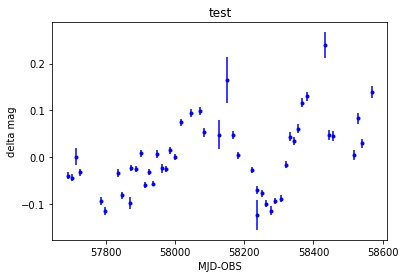

In [29]:
# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2_phot_v02.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_agn[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [26]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_agn[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')
Htemp=delta_mag_agn_ref1[maskH]
Hisnan=~np.isnan(Htemp)
xH=np.asarray(mjd_obs[maskH][Hisnan], dtype=float)
nH=len(xH)
XH = np.reshape(xH,(nH,1))
yH=np.asarray(delta_mag_agn_ref1[maskH][Hisnan]-np.median(delta_mag_agn_ref1[maskH][Hisnan]), dtype=float)
yHerr = np.asarray(magerr_agn[maskH][Hisnan], dtype=float)

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_agn[maskK], dtype=float)

#g band data
maskg = (filt == 'g')
gtemp=delta_mag_agn_ref1[maskg]
gisnan=~np.isnan(gtemp)
xg=np.asarray(mjd_obs[maskg][gisnan], dtype=float)
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
yg=np.asarray(delta_mag_agn_ref1[maskg][gisnan]-np.median(delta_mag_agn_ref1[maskg][gisnan]), dtype=float)
ygerr = np.asarray(magerr_agn[maskg][gisnan], dtype=float)
#remove values 
xg=xg[(yg>-0.4) & (yg<0.4)]
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
ygerr=ygerr[(yg>-0.4) & (yg<0.4)]
yg=yg[(yg>-0.4) & (yg<0.4)]

#r band data
maskr = (filt == 'r')
rtemp=delta_mag_agn_ref1[maskr]
risnan=~np.isnan(rtemp)
xr=np.asarray(mjd_obs[maskr][risnan], dtype=float)
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yr=np.asarray(delta_mag_agn_ref1[maskr][risnan]-np.median(delta_mag_agn_ref1[maskr][risnan]), dtype=float)
yrerr = np.asarray(magerr_agn[maskr][risnan], dtype=float)
#remove values 
xr=xr[(yr>-0.4) & (yr<0.4)]
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yrerr=yrerr[(yr>-0.4) & (yr<0.4)]
yr=yr[(yr>-0.4) & (yr<0.4)]

#i band data
maski = (filt == 'i')
itemp=delta_mag_agn_ref1[maski]
iisnan=~np.isnan(itemp)
xi=np.asarray(mjd_obs[maski][iisnan], dtype=float)
ni=len(xi)
Xi = np.reshape(xi,(ni,1))
yi=np.asarray(delta_mag_agn_ref1[maski][iisnan]-np.median(delta_mag_agn_ref1[maski][iisnan]), dtype=float)
yierr = np.asarray(magerr_agn[maski][iisnan], dtype=float)
#remove values 
xi=xi[(yi>-0.4) & (yi<0.4)]
ni=len(xi)
Xi= np.reshape(xi,(ni,1))
yierr=yierr[(yi>-0.4) & (yi<0.4)]
yi=yi[(yi>-0.4) & (yi<0.4)]

#z band data
maskz = (filt == 'z')
ztemp=delta_mag_agn_ref1[maskz]
zisnan=~np.isnan(ztemp)
xz=np.asarray(mjd_obs[maskz][zisnan], dtype=float)
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yz=np.asarray(delta_mag_agn_ref1[maskz][zisnan]-np.median(delta_mag_agn_ref1[maskz][zisnan]), dtype=float)
yzerr = np.asarray(magerr_agn[maskz][zisnan], dtype=float)
#remove values 
xz=xz[(yz>-0.4) & (yz<0.4)]
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yzerr=yzerr[(yz>-0.4) & (yz<0.4)]
yz=yz[(yz>-0.4) & (yz<0.4)]

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK,xg,xr,xi,xz),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)

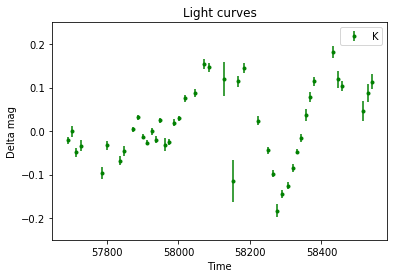

In [28]:
#plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
#plt.errorbar(xH, yH, yHerr,fmt='r.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='g.',label='K')
#plt.errorbar(xg, yg, ygerr,fmt='c.',label='g')
#plt.errorbar(xr, yr, yrerr,fmt='m.',label='r')
#plt.errorbar(xi, yi, yierr,fmt='y.',label='i')
#plt.errorbar(xz, yz, yzerr,fmt='k.',label='z')

plt.ylim(-0.25,0.25)
#plt.xlim(58200,58400)
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

# Combine data points

In [152]:
print(xg[0:3])
print(xg[3:6])
print(xg[6:9])
print(xg[9:12])
print(xg[12:15])
print(xg[15])
print(xg[16:19])
print(xg[19:22])
print(xg[22:25])
print(xg[25:28])
print(xg[28:31])
print(xg[31])
print(xg[32])
print(xg[33])
print(xg[34:36])
print(xg[36:39])
print(xg[39:42])
print(xg[42:45])
print(xg[45:48])
print(xg[48:50])
print(xg[50:53])
print(xg[53:56])
print(xg[56:58])
print(xg[58:61])
print(xg[61:64])
print(xg[64:67])
print(xg[67:70])
print(xg[70:73])
print(xg[73:76])
print(xg[76:79])
print(xg[79:82])
print(xg[82:85])
print(xg[85:88])
print(xg[88:91])

[57690.1558053 57690.1578785 57690.1599501]
[57714.0926328 57714.0946803 57714.0967258]
[57727.0577714 57727.059818  57727.0618634]
[57785.3366939 57785.3387671 57785.3408377]
[57799.3365427 57799.3386169 57799.3406711]
57870.3807495
[57872.3467083 57872.348781  57872.3508274]
[57901.2941713 57901.2962195 57901.2982903]
[57913.2612585 57913.263306  57913.2653501]
[57925.1230267 57925.1250735 57925.1271487]
[57949.1624252 57949.1644727 57949.1665225]
57962.1287033
57974.0979079
57987.047722
[58047.2079666 58047.2100395]
[58072.0497473 58072.0517936 58072.0538395]
[58127.353073  58127.3551229 58127.3571969]
[58166.3257914 58166.3278644 58166.3299096]
[58222.3145811 58222.3166286 58222.3186739]
[58250.3402352 58250.3444066]
[58263.3045405 58263.3065859 58263.3086322]
[58289.2408928 58289.2429393 58289.2450109]
[58307.1843439 58307.1863879]
[58320.1216738 58320.1237213 58320.1257965]
[58332.1150159 58332.1170922 58332.1191399]
[58344.0807702 58344.0828687 58344.0849411]
[58368.3304116 5836

array([], dtype=float64)

In [56]:
ygerr[0:3]

array([0.00397403, 0.00395333, 0.00396734])

<ErrorbarContainer object of 3 artists>

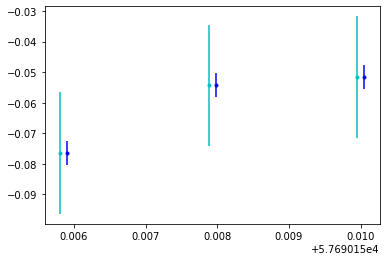

In [73]:
plt.errorbar(0.0001+xg[0:3], yg[0:3], ygerr[0:3],fmt='b.',label='g')
plt.errorbar(xg[0:3], yg[0:3], 5*ygerr[0:3],fmt='c.',label='g')


In [229]:
newx=np.zeros(34)
newy=np.zeros(34)
newyerr=np.zeros(34)


start=[0,3,6,9,12,15,16,19,22,25,28,31,32,33,34,36,39,43,45,48,50,53,56,58,61,64,67,70,73,76,79,82,85,88]
end=[3,6,9,12,15,15,19,22,25,28,31,31,32,33,36,39,42,45,48,50,53,56,58,61,64,67,70,73,76,79,82,85,88,91]

for i in range(0,34):
    if start[i] == end[i]:
        newx[i]=xg[start[i]]
        newy[i]=yg[start[i]]
        newyerr[i]=ygerr[start[i]]
    else:
        newx[i]=np.mean(xg[start[i]:end[i]])
        newy[i]=np.mean(yg[start[i]:end[i]])
        newyerr[i]=(max(yg[start[i]:end[i]])-min(yg[start[i]:end[i]]))/2.0
        
        #if end[i]-start[i]==3:
        #    newyerr[i]=np.sqrt((ygerr[start[i]]**2)+(ygerr[start[i]+1]**2)+(ygerr[start[i]+2]**2))/3.0
        #elif end[i]-start[i]==2:
        #    newyerr[i]=np.sqrt((ygerr[start[i]]**2)+(ygerr[start[i]+1]**2))/2.0
        

In [230]:
newyerr

array([1.24769211e-02, 5.14984131e-02, 8.73184204e-03, 1.44977570e-02,
       5.88607788e-03, 4.53888392e-03, 3.35016251e-02, 1.12142563e-02,
       1.57041550e-02, 6.38294220e-03, 7.52067566e-03, 7.37878866e-03,
       5.12537779e-03, 3.38575337e-03, 3.14712524e-05, 2.19688416e-02,
       3.92951965e-02, 1.49106979e-02, 1.03340149e-02, 4.89234924e-03,
       1.10273361e-02, 3.55720520e-03, 6.18934631e-04, 1.55868530e-02,
       1.46684647e-02, 1.13897324e-02, 1.65052414e-02, 1.30977631e-02,
       1.78709030e-02, 2.12955475e-03, 2.62193680e-02, 1.03788376e-02,
       2.43911743e-02, 2.65960693e-02])

<ErrorbarContainer object of 3 artists>

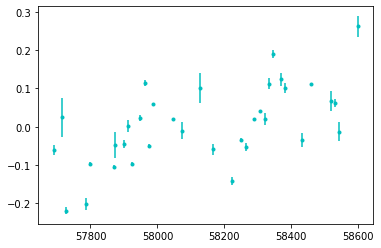

In [234]:
plt.errorbar(newx, newy, newyerr,fmt='c.',label='new g')
#plt.errorbar(xg, yg, ygerr,fmt='b.',label='g')
#plt.errorbar(xK, yK, yKerr,fmt='g.',label='K')

In [224]:
print(xK-min(xK))

[  0.        11.885684  23.936849  36.901938  95.180896 109.18074
 145.188422 157.062172 182.190904 197.178206 211.138338 223.105428
 234.967194 247.030978 259.00659  271.970842 283.937964 296.891876
 310.1475   328.076698 357.052162 381.8939   393.899236 437.19724
 461.131338 476.169988 493.166796 532.158744 560.184468 573.148688
 586.209084 599.085064 617.026458 629.96585  641.959212 653.925004
 665.891876 678.174572 690.13276  742.958232 754.893836 767.902292
 827.190958 839.178918 851.188796]


In [264]:
print(yierr)

[0.00298699 0.0029724  0.00297391 0.00350339 0.00356852 0.00341163
 0.0049513  0.00601686 0.00512889 0.00320513 0.00319594 0.00320182
 0.00333633 0.00334465 0.00343626 0.00393661 0.00392925 0.00391526
 0.00324846 0.00326502 0.00326896 0.00243152 0.00243063 0.00242924
 0.00312081 0.00321634 0.00324197 0.00292102 0.00303648 0.00304085
 0.00360923 0.0036519  0.00367785 0.00283886 0.00296593 0.00270843
 0.00267531 0.0026844  0.00271468 0.00322356 0.00430757 0.003384
 0.00369312 0.00662155 0.00404542 0.00310351 0.00308007 0.00307963
 0.00274064 0.00270908 0.00270801 0.00322657 0.00327019 0.00327992
 0.00282894 0.00287057 0.00290254 0.00325668 0.00324608 0.00322059
 0.00299689 0.0029827  0.00298079 0.00321333 0.00322805 0.00322407
 0.01213106 0.01046622 0.00930025 0.0032793  0.00326038 0.00322229
 0.00353992 0.00353399 0.00349565 0.0030959  0.00307177 0.00307414
 0.00415243 0.00375377 0.00568246 0.0212427  0.00301407 0.00301496
 0.00299514 0.00326769 0.00324302 0.00320815 0.00415503 0.005726

In [265]:
starti=[0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,81,85,88,91,94,97,100,103,106,
     109,112,115,118,121,124,127,130]
endi=[3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,81,85,88,91,94,97,100,103,106,
     109,112,115,118,121,124,127,130,133]

newxi=np.zeros(len(endi))
newyi=np.zeros(len(endi))
newyierr=np.zeros(len(endi))

for i in range(0,45):
    if starti[i] == endi[i]:
        newxi[i]=xi[starti[i]]
        newyi[i]=yi[starti[i]]
        newyierr[i]=yierr[starti[i]]
    else:
        newxi[i]=np.mean(xi[starti[i]:endi[i]])
        newyi[i]=np.mean(yi[starti[i]:endi[i]])
        newyierr[i]=(max(yi[starti[i]:endi[i]])-min(yi[starti[i]:endi[i]]))/2.0
        
        #if endi[i]-starti[i]==3:
        #    newyierr[i]=np.sqrt((yierr[starti[i]]**2)+(yierr[starti[i]+1]**2)+(yierr[starti[i]+2]**2))/3.0
        #elif endi[i]-starti[i]==2:
        #    newyierr[i]=np.sqrt((yierr[starti[i]]**2)+(yierr[starti[i]+1]**2))/2.0
                

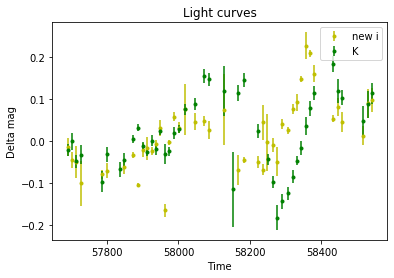

In [268]:
#plt.errorbar(newx, newy, newyerr,fmt='c.',label='new g')
plt.errorbar(newxi, newyi, 2*newyierr,fmt='y.',label='new i')
#plt.errorbar(xg, yg, ygerr,fmt='b.',label='g')
plt.errorbar(xK, yK, yKerr,fmt='g.',label='K')

#plt.ylim(-1,1)
#plt.xlim(58200,58400)
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()